In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2 as cv
import numpy as np
from scipy import ndimage

In [2]:
def showimg(ax, img, title=None, cmap='viridis'):
    if len(img.shape) == 2:
        cmap = 'gray'
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

def showimgs(rows, cols, imgs, titles=None, cmap='viridis'):
    dpi = mpl.rcParams['figure.dpi']
    figsize = (400/dpi*cols, 400/dpi*rows)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    try:
        axes = axes.reshape(-1)
    except AttributeError:
        axes = [axes]
    for ax, img, title in zip(axes, imgs, titles):
        showimg(ax, img, title, cmap)
    plt.show()


def get_rgb_img(img_name):
    img = cv.imread('../images/' + img_name)
    img = img[:, :, ::-1]
    return cv.resize(img, (400, 400), interpolation=cv.INTER_AREA)


def get_gray_img(img_name):
    img = cv.imread('../images/' + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return cv.resize(img, (400, 400), interpolation=cv.INTER_AREA)

In [3]:
mpl.rc('font', family='dengxian')
# mpl.style.use('ggplot')

# 实验一

## 1.1 图像的读取操作

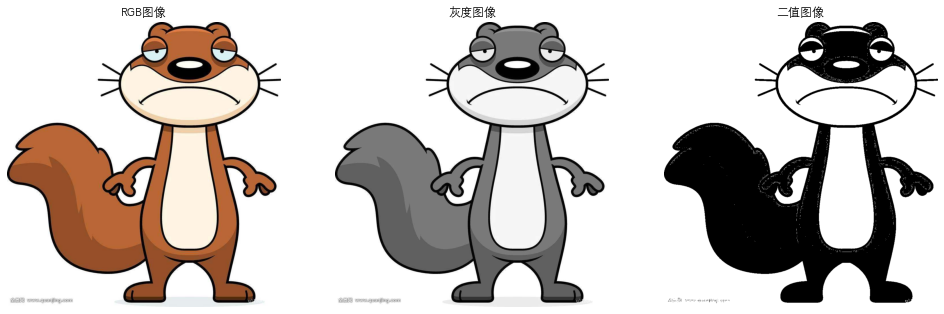

In [4]:
img = cv.imread('../images/005.jpg')
img_rgb = img[:, :, ::-1]
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, img_binary = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY)
images = [img_rgb, img_gray, img_binary]
titles = ['RGB图像', '灰度图像', '二值图像']
showimgs(1, 3, images, titles)

## 1.2 图像的基本运算

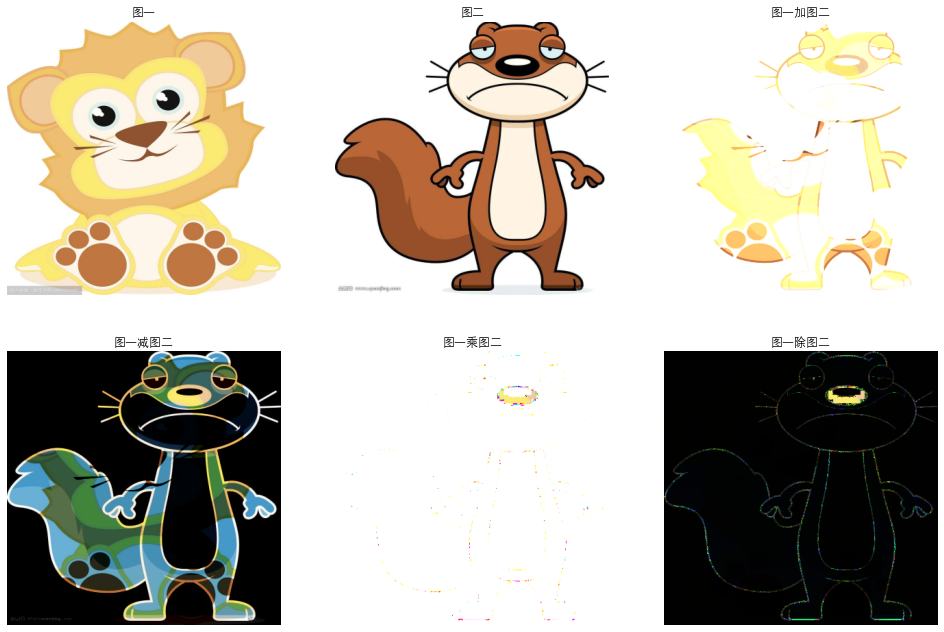

In [5]:
img1 = get_rgb_img('001.jpg')
img2 = get_rgb_img('005.jpg')
img_add = cv.add(img1, img2)
img_subtract = cv.subtract(img1, img2)
img_multply = cv.multiply(img1, img2)
img_divide = cv.divide(img1, img2)

imgs = [img1, img2, img_add, img_subtract, img_multply, img_divide]
titles = ['图一', '图二', '图一加图二', '图一减图二', '图一乘图二', '图一除图二']
showimgs(2, 3, imgs, titles)

## 1.3 图像的几何变换

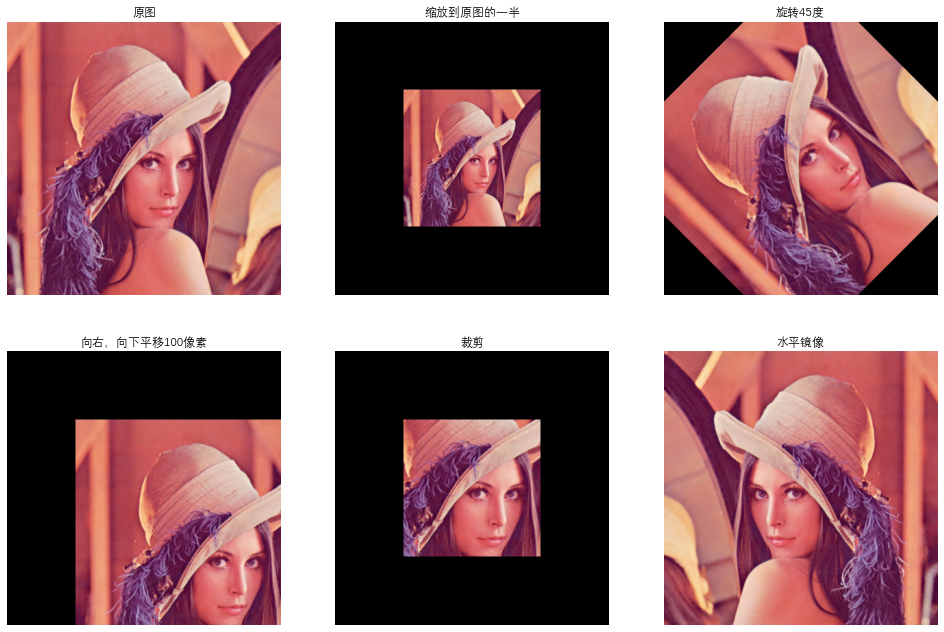

In [6]:
img_raw = get_rgb_img('lena512color.tiff')
# matplotlib的imshow会对自动对图片做缩放操作，为了展示缩放，和裁剪的结果，将其放入一个和原图相同形状的空图中间
blank1 = np.zeros_like(img_raw)
blank2 = np.zeros_like(img_raw)
img_resize = cv.resize(img_raw, (200, 200), interpolation=cv.INTER_AREA)
blank1[100:300, 100:300] = img_resize
w, h = 400, 400
M_rotate = cv.getRotationMatrix2D((h / 2, w / 2), 45, 1)
img_rotate = cv.warpAffine(img_raw, M_rotate, (w, h))
M_translate = np.float32([
    [1, 0, 100],
    [0, 1, 100],
])
img_translate = cv.warpAffine(img_raw, M_translate, (w, h))
img_crop = img_raw[100:300, 100:300]
blank2[100:300, 100:300] = img_crop
img_flip = img_raw[:, ::-1, :]

imgs = [img_raw, blank1, img_rotate, img_translate, blank2, img_flip]
titles = ['原图', '缩放到原图的一半', '旋转45度', '向右，向下平移100像素', '裁剪', '水平镜像']
showimgs(2, 3, imgs, titles)


## 1.4 图像的灰度变换

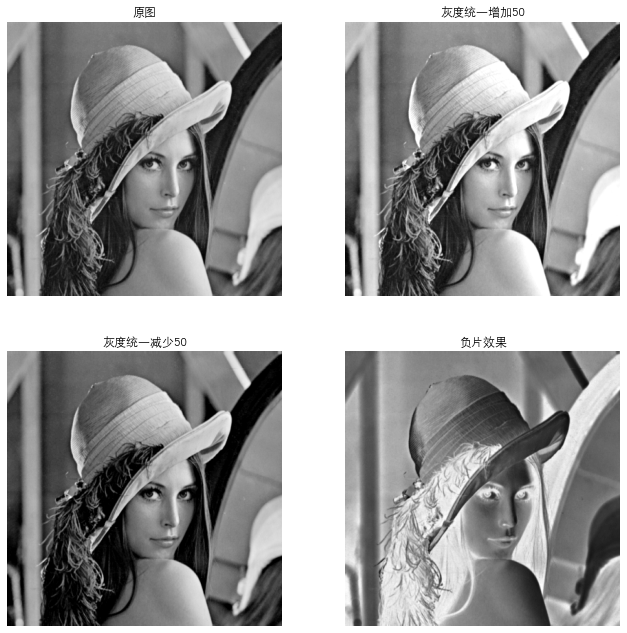

In [7]:
img_raw = get_gray_img('lena512color.tiff')
b1 = np.ones_like(img_raw) * 50
b2 = np.ones_like(img_raw) * 255
img_lighter = cv.add(img_raw, b1)
img_darker = cv.subtract(img_raw, b1)
img_revert = cv.subtract(b2, img_raw)

imgs = [img_raw, img_lighter, img_darker, img_revert]
titles = ['原图', '灰度统一增加50', '灰度统一减少50', '负片效果']
showimgs(2, 2, imgs, titles)

# 实验二

## 2.1 图像的平滑处理

In [8]:
def sp_noise(image, prob):
    '''
    添加椒盐噪声
    prob:噪声比例 
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.rand()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


def gaussian_noise(image, mean=0, var=0.01):
    ''' 
        添加高斯噪声
        mean : 均值 
        var : 标准差
    '''
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    # imshow会将图像的像素值标准化，因此输入图像可以有负数
    return out


def gamma_noise(image, k, theta=1):
    ''' 
        添加高斯噪声
        mean : 均值 
        var : 标准差
    '''
    image = np.array(image/255, dtype=float)
    # k为形状参数， theta为尺度参数
    noise = np.random.gamma(k, theta, image.shape)
    out = image * noise
    out = np.clip(out, 0.0, 1.0)
    out = np.uint8(out*255)
    return out

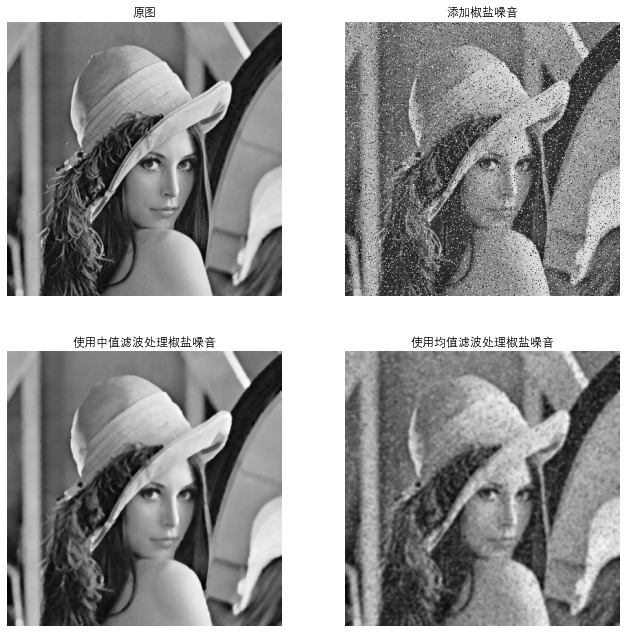

In [9]:
img_raw = get_gray_img('lena512color.tiff')
img_sp = sp_noise(img_raw, 0.05)
img_median_blur = cv.medianBlur(img_sp, 5)
img_mean_blur = cv.blur(img_sp, (5, 5))
imgs = [img_raw, img_sp, img_median_blur, img_mean_blur]
titles = ['原图', '添加椒盐噪音', '使用中值滤波处理椒盐噪音', '使用均值滤波处理椒盐噪音']
showimgs(2, 2, imgs, titles)

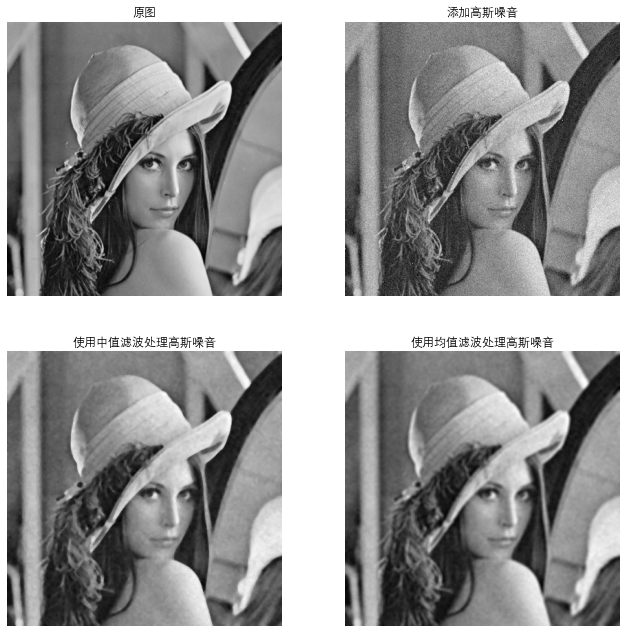

In [10]:
img_raw = get_gray_img('lena512color.tiff')
img_sp = gaussian_noise(img_raw, 0, 0.05)
img_median_blur = cv.medianBlur(img_sp, 5)
img_mean_blur = cv.blur(img_sp, (5, 5))
imgs = [img_raw, img_sp, img_median_blur, img_mean_blur]
titles = ['原图', '添加高斯噪音', '使用中值滤波处理高斯噪音', '使用均值滤波处理高斯噪音']
showimgs(2, 2, imgs, titles)

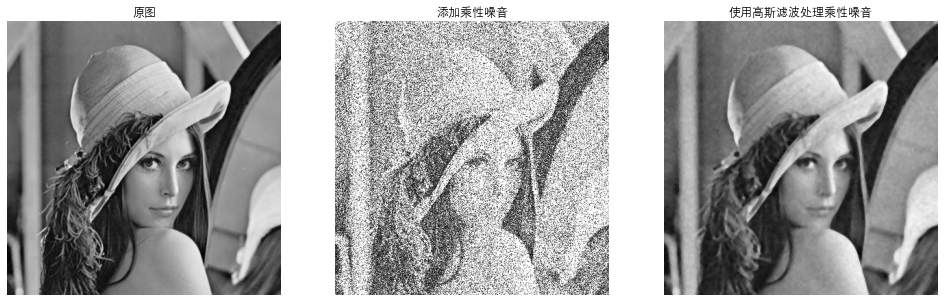

In [11]:
img_raw = get_gray_img('lena512color.tiff')
img_mul_nosie = gamma_noise(img_raw, 2, 1)
img_gaussian_blur = cv.GaussianBlur(img_mul_nosie, (5, 5), 0)
imgs = [img_raw, img_mul_nosie, img_median_blur]
titles = ['原图', '添加乘性噪音', '使用高斯滤波处理乘性噪音']
showimgs(1, 3, imgs, titles)

## 图像增强

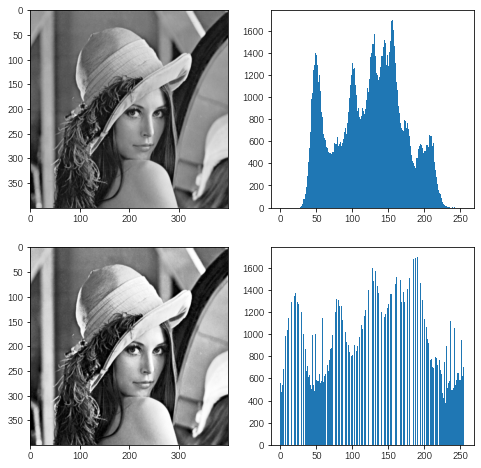

In [12]:
img_gray = get_gray_img('lena512color.tiff')
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.reshape(-1)
axes[0].imshow(img_gray, cmap='gray')
axes[1].hist(img_gray.flatten(), 256, [0, 256])
# equ = cv.equalizeHist(img_gray) # 直方图均衡化
# axes[2].imshow(equ, cmap='gray')
# axes[3].hist(equ.flatten(), 256, [0, 256])

# 手动实现直方图均衡化
hist, bins = np.histogram(img_gray.flatten(), 256, [0, 256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8') # 这里cdf实际是h(v)了
img2 = cdf[img_gray]
axes[3].hist(img2.flatten(), 256, [0, 256])
axes[2].imshow(img2, cmap='gray')

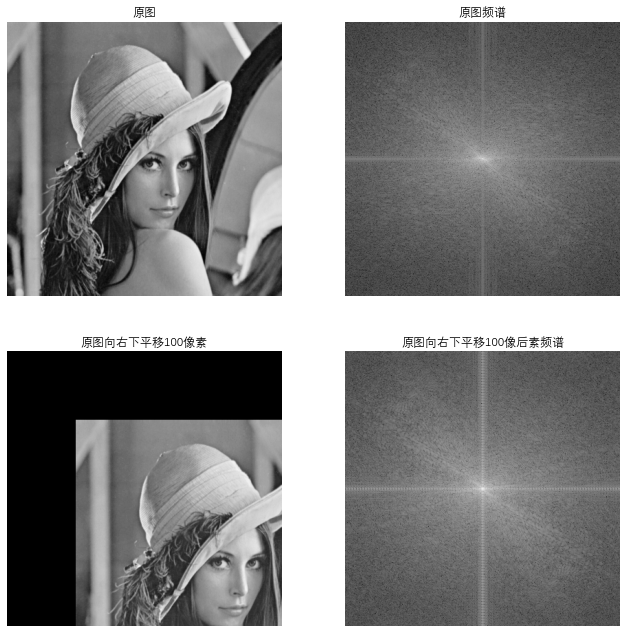

In [13]:
img_gray = get_gray_img('lena512color.tiff')
img_gray_fft = cv.dft(np.float32(img_gray), flags=cv.DFT_COMPLEX_OUTPUT) # 返回值为复数
img_gray_fft_shift = np.fft.fftshift(img_gray_fft)
img_gray_magnitude_spectrum = 20 * np.log(
    cv.magnitude(img_gray_fft_shift[:, :, 0],
                 img_gray_fft_shift[:, :, 1]))
M = np.float32([[1, 0, 100],
     [0, 1, 100]])
img_trans = cv.warpAffine(img_gray, M, img_gray.shape[:2])
img_trans_fft = cv.dft(np.float32(img_trans), flags=cv.DFT_COMPLEX_OUTPUT)
img_trans_fft_shift = np.fft.fftshift(img_trans_fft)
img_trans_magnitude_spectrum = 20 * np.log(
    cv.magnitude(img_trans_fft_shift[:, :, 0],
                 img_trans_fft_shift[:, :, 1]))
imgs = [img_gray, img_gray_magnitude_spectrum, img_trans, img_trans_magnitude_spectrum]
titles = ['原图', '原图频谱', '原图向右下平移100像素', '原图向右下平移100像后素频谱']
showimgs(2, 2, imgs, titles)

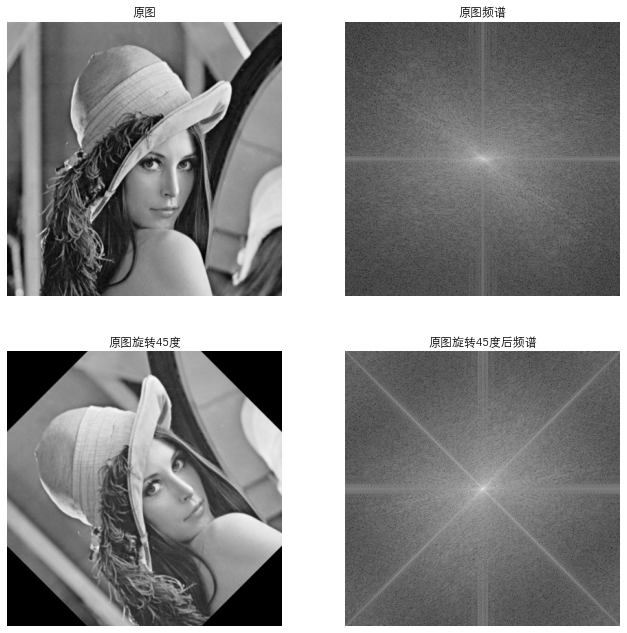

In [14]:
img_gray = get_gray_img('lena512color.tiff')
img_gray_fft = cv.dft(np.float32(img_gray),
                      flags=cv.DFT_COMPLEX_OUTPUT)  # 返回值为复数
img_gray_fft_shift = np.fft.fftshift(img_gray_fft)
img_gray_magnitude_spectrum = 20 * np.log(
    cv.magnitude(img_gray_fft_shift[:, :, 0],
                 img_gray_fft_shift[:, :, 1]))
M = cv.getRotationMatrix2D((h / 2, w / 2), 45, 1)
img_rot = cv.warpAffine(img_gray, M, img_gray.shape[:2])
img_rot_fft = cv.dft(np.float32(img_rot), flags=cv.DFT_COMPLEX_OUTPUT)
img_rot_fft_shift = np.fft.fftshift(img_rot_fft)
img_rot_magnitude_spectrum = 20 * np.log(
    cv.magnitude(img_rot_fft_shift[:, :, 0],
                 img_rot_fft_shift[:, :, 1]))
imgs = [img_gray, img_gray_magnitude_spectrum,
        img_rot, img_rot_magnitude_spectrum]
titles = ['原图', '原图频谱', '原图旋转45度', '原图旋转45度后频谱']
showimgs(2, 2, imgs, titles)

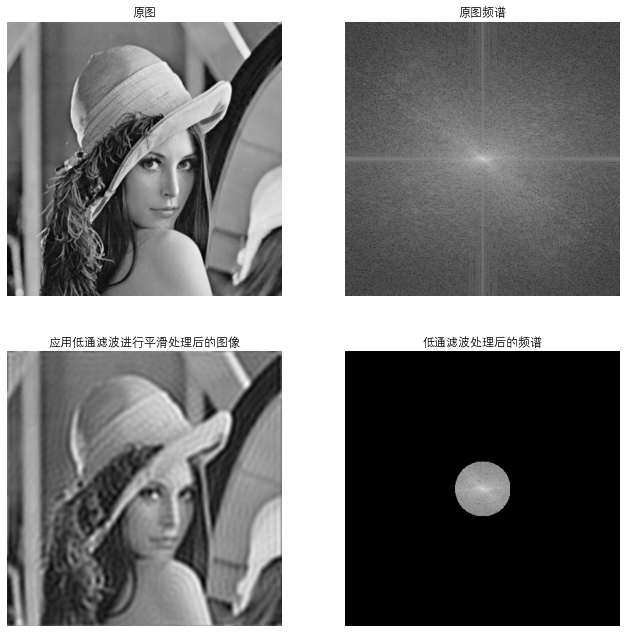

In [15]:
img_gray = get_gray_img('lena512color.tiff')
img_gray_fft = cv.dft(np.float32(img_gray),
                      flags=cv.DFT_COMPLEX_OUTPUT)  # 返回值为复数
img_gray_fft_shift = np.fft.fftshift(img_gray_fft)
img_gray_magnitude_spectrum = 20 * np.log(
    cv.magnitude(img_gray_fft_shift[:, :, 0],
                 img_gray_fft_shift[:, :, 1]))
w, h = img_gray.shape[:2]
crow, ccol = w//2, h//2
mask = np.zeros((w, h, 2))
mask1 = np.zeros((w, h))
circle = cv.getStructuringElement(cv.MORPH_ELLIPSE, (80, 80))
mask[crow-40:crow+40, ccol-40:ccol+40] = np.expand_dims(circle, axis=2)
mask1[crow-40:crow+40, ccol-40:ccol+40] = circle
# 应用低通滤波
fshift = img_gray_fft_shift * mask
lps_magnitude_spectrum = img_gray_magnitude_spectrum * mask1
# 把DC分量移回左上角
f_ishift = np.fft.ifftshift(fshift)
# 逆傅里叶变换，复原图像
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
imgs = [img_gray, img_gray_magnitude_spectrum,
        img_back, lps_magnitude_spectrum]
titles = ['原图', '原图频谱', '应用低通滤波进行平滑处理后的图像', '低通滤波处理后的频谱']
showimgs(2, 2, imgs, titles)

# 实验三

## 边缘分割

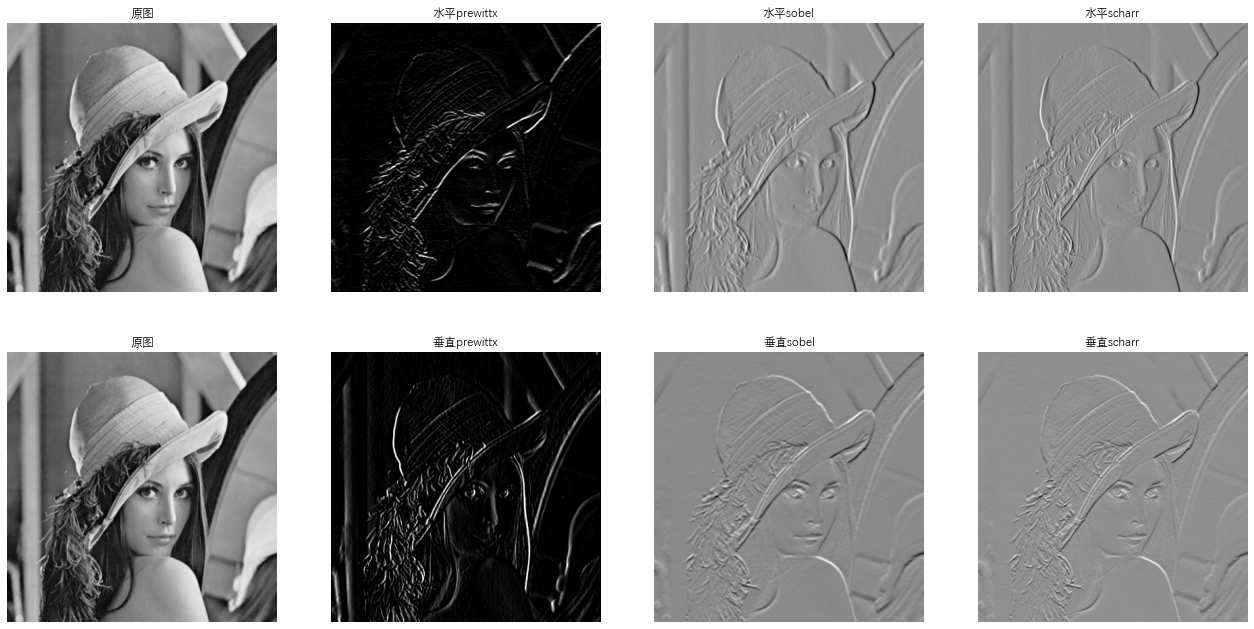

In [16]:
img = get_gray_img('lena512color.tiff')
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
scharrx = cv.Scharr(img, cv.CV_64F, 1, 0)
scharry = cv.Scharr(img, cv.CV_64F, 0, 1)
kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewittx = cv.filter2D(img, -1, kernelx)
prewitty = cv.filter2D(img, -1, kernely)

imgs = [img, prewittx,  sobelx,  scharrx, img, prewitty, sobely, scharry]
titles = ['原图', '水平prewittx', '水平sobel', '水平scharr',
          '原图', '垂直prewittx', '垂直sobel', '垂直scharr']
showimgs(2, 4, imgs, titles)

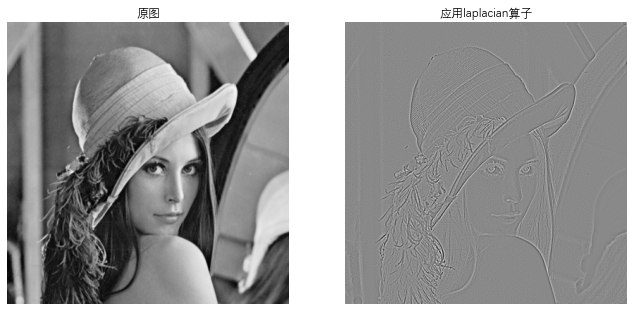

In [17]:
img = get_gray_img('lena512color.tiff')
laplacian = cv.Laplacian(img, cv.CV_64F, ksize=1)
showimgs(1, 2, [img, laplacian], ['原图', '应用laplacian算子'])

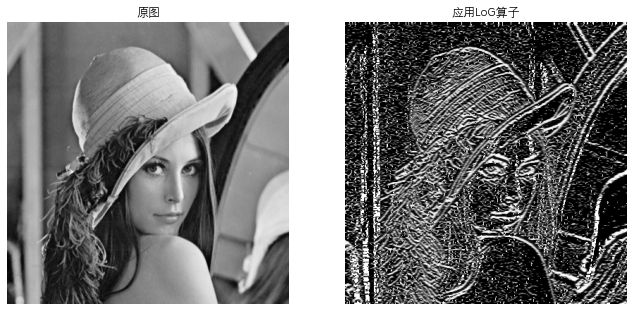

In [18]:
img_gray = get_gray_img('lena512color.tiff')
laplacian = ndimage.gaussian_laplace(img_gray, sigma=1)
showimgs(1, 2, [img, laplacian], ['原图', '应用LoG算子'])

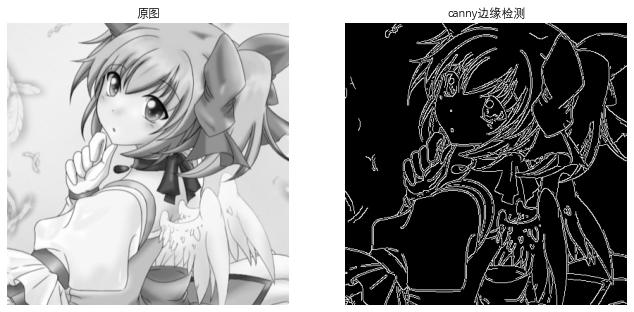

In [27]:
img = get_gray_img('madoka.jpg')
canny = cv.Canny(img, 100, 200)
showimgs(1, 2, [img, canny], ['原图', 'canny边缘检测'])

## 阈值分割

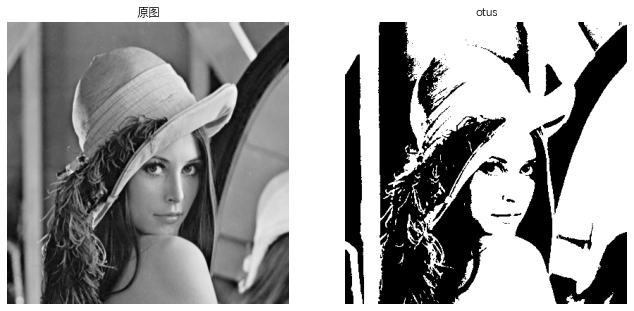

In [20]:
img = get_gray_img('lena512color.tiff')
# Otsu二值化算法， 阈值会自动计算，所以第二个参数没用  
ret, otus = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
showimgs(1, 2, [img, otus], ['原图', 'otus'])

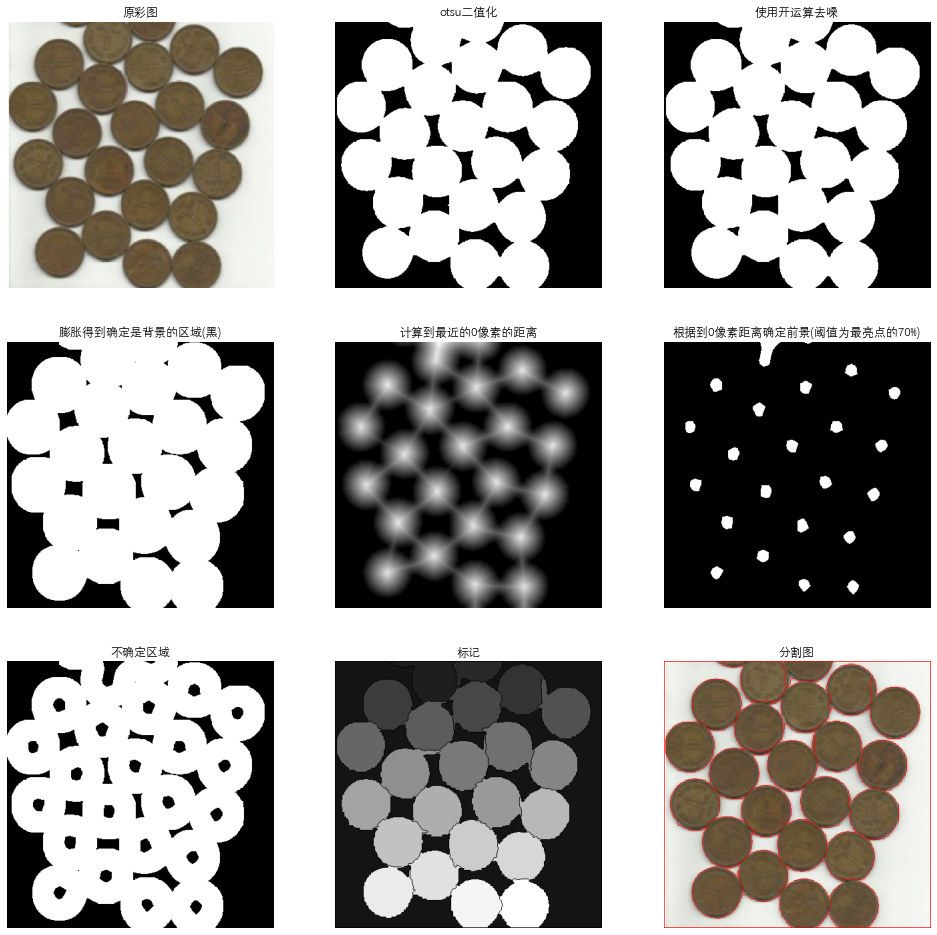

In [21]:
img_rgb = get_rgb_img('coins.png')
img = img_rgb.copy()
img_gray = get_gray_img('coins.png')
ret, otsu = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
# 噪声去除
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel, iterations=2)
# 确定背景区域
sure_bg = cv.dilate(opening, kernel, iterations=3)
# 寻找前景区域
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, cv.THRESH_BINARY)
# 找到未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)
# 类别标记
ret, markers = cv.connectedComponents(sure_fg)
# 为所有的标记加1，保证背景是1，未确定区域会被设为0
markers = markers+1
# 现在让所有的未知区域为0
markers[unknown == 255] = 0
w_markers = cv.watershed(img, markers)
img[w_markers == -1] = [255, 0, 0]

imgs = [img_rgb, otsu, opening, sure_bg, dist_transform, sure_fg, unknown, w_markers, img]
titles = ['原彩图', 'otsu二值化', '使用开运算去噪', '膨胀得到确定是背景的区域(黑)', '计算到最近的0像素的距离', '根据到0像素距离确定前景(阈值为最亮点的70%)', '不确定区域', '标记', '分割图']
showimgs(3, 3, imgs, titles)


# 实验四

## 开运算和闭运算

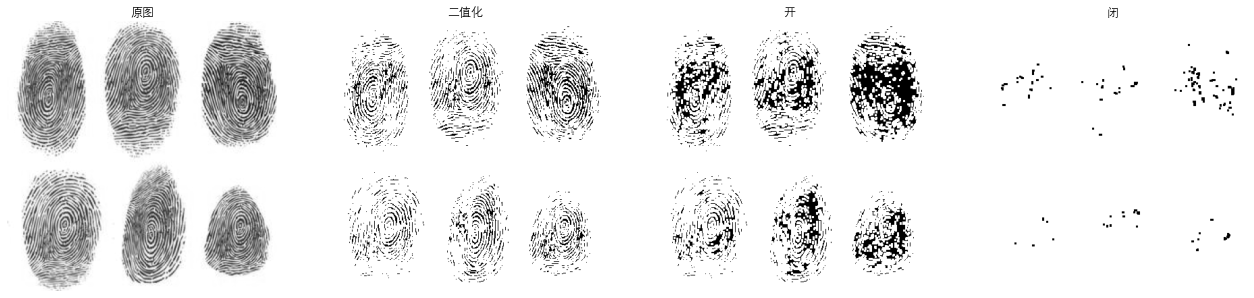

In [22]:
img_gray = get_gray_img('fingerprint.jpg')
_, img_thresh = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
kernel = np.ones((3, 3))
opening = cv.morphologyEx(img_thresh, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(img_thresh, cv.MORPH_CLOSE, kernel)
imgs = [img_gray, img_thresh, opening, closing]
titles = ['原图', '二值化', '开', '闭']
showimgs(1, 4, imgs, titles)

## 顶帽和底帽

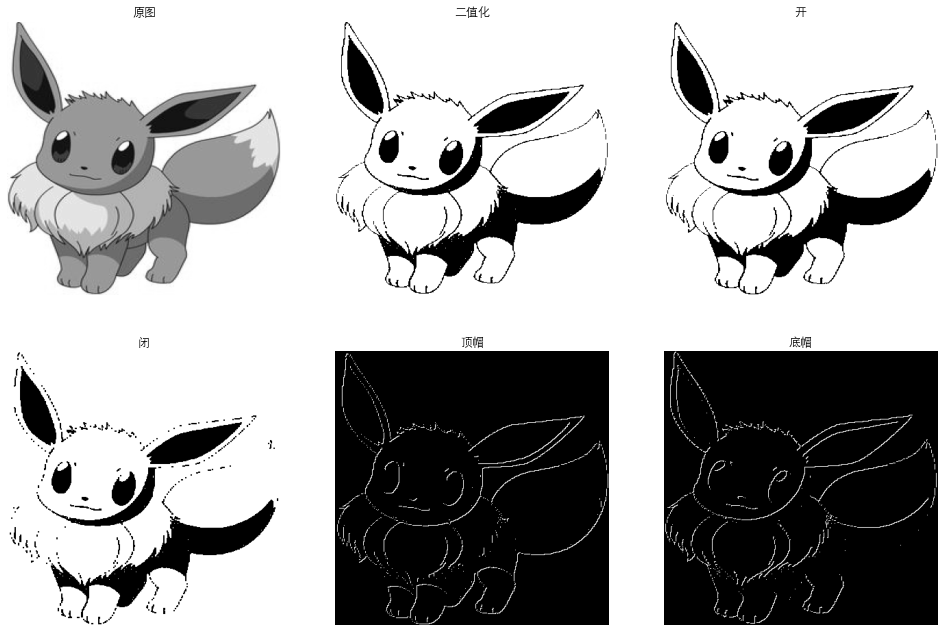

In [23]:
img_gray = get_gray_img('yibu.jpg')
_, img_thresh = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
kernel = np.ones((2, 2))
opening = cv.morphologyEx(img_thresh, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(img_thresh, cv.MORPH_CLOSE, kernel)
# tophat input-open
tophat = cv.morphologyEx(img_thresh, cv.MORPH_TOPHAT, kernel)
# blackhat input-close
blackhat = cv.morphologyEx(img_thresh, cv.MORPH_BLACKHAT, kernel)
imgs = [img_gray, img_thresh,  opening, closing, tophat, blackhat]
titles = ['原图', '二值化', '开', '闭', '顶帽', '底帽']
showimgs(2, 3, imgs, titles)

## 击中和不击中

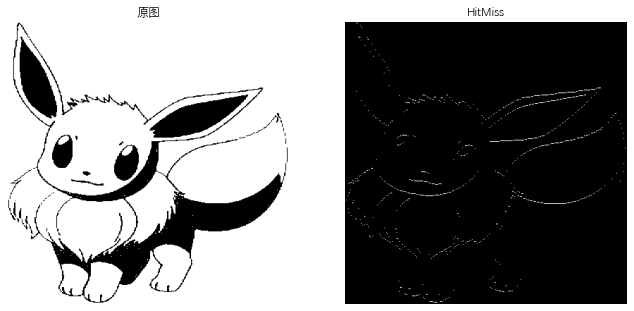

In [24]:
img_gray = get_gray_img('yibu.jpg')
_, img_thresh = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
kernel = np.array([
    [1, 1, 1],
    [0, -1, 0],
    [0, 0, 0]
])
hitmiss = cv.morphologyEx(img_thresh, cv.MORPH_HITMISS, kernel)
showimgs(1,2, [img_thresh, hitmiss], ['原图', 'HitMiss'])

## 图像填充

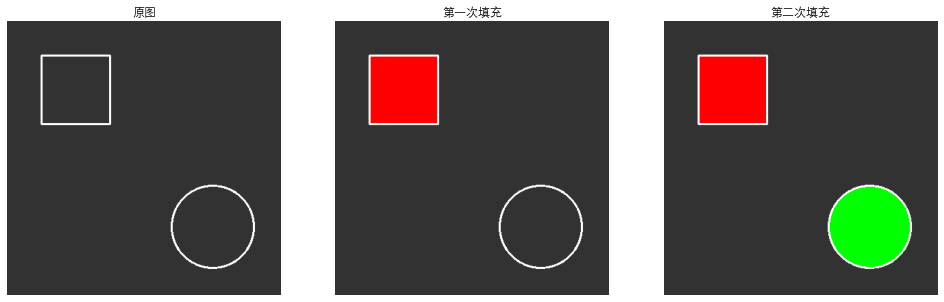

In [25]:
img = np.zeros((400, 400, 3), dtype=np.uint8)
img[:, :] = (50, 50, 50)
cv.rectangle(img, (50, 50), (150, 150), (255, 255, 255), thickness=2)
cv.circle(img, (300, 300), 60, (255, 255, 255), thickness=2)
mask = np.zeros((img.shape[0]+2, img.shape[1]+2), dtype=np.uint8)
img_fill1 = img.copy()
cv.floodFill(img_fill1, mask, (100, 100), (255, 0, 0), flags=cv.FLOODFILL_FIXED_RANGE)
img_fill2 = img_fill1.copy()
cv.floodFill(img_fill2, mask, (280, 280), (0, 255, 0), flags=cv.FLOODFILL_FIXED_RANGE)
imgs = [img, img_fill1, img_fill2]
titles = ['原图', '第一次填充', '第二次填充']
showimgs(1, 3, imgs, titles)